In [1]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rcParams
import seaborn as sns
import numpy as np
import os
import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
    
from umap_embedding import get_umap_embedding, plot_umap

### Apply UMAP to multimodal features

In [2]:
# Load extracted multimodal features, preprocess, and apply UMAP
df = get_umap_embedding("../features", umap_min_dist=0.1, umap_n_neighbors=15)
df.head()

,patient_id,sex,primarily_metastasis,smoking_status,age_at_initial_diagnosis,perinodal_invasion,lymphovascular_invasion_L,vascular_invasion_V,perineural_invasion_Pn,carcinoma_in_situ,...,d380,r590,r599,t810,cd3_z,cd3_inv,cd8_z,cd8_inv,UMAP 1,UMAP 2
0,001,0,0.0,0,65,1.0,1,0,0,0,...,0,0,0,0,1909.950,1027.860,5470.500,4674.550,0.528702,0.988135
1,002,0,1.0,2,62,1.0,1,0,0,0,...,0,0,0,0,688.920,399.360,570.210,411.505,0.310377,0.443665
2,003,0,0.0,1,60,0.0,0,0,0,0,...,0,0,0,0,3781.000,2687.500,1556.400,461.490,0.387398,0.940988
3,004,0,0.0,2,55,NaN,0,0,0,1,...,0,0,0,0,294.595,795.895,119.855,482.065,0.354550,0.273301
4,006,0,0.0,0,65,1.0,0,0,0,0,...,0,0,0,0,460.455,1742.150,110.115,80.530,0.381563,0.581709


### Plot colored 2D embeddings
Each point in the plot represents a patient. The points are colored by different features.

In [3]:
# Make strings more readable
# (You can check how the features are encoded by running 'create_multimodal_patient_vectors' with --verbose)

df.hpv_association_p16 = df.hpv_association_p16.replace({0: "negative", 1: "not tested", 2: "positive"})
df.smoking_status = df.smoking_status.replace({0: "former", 1: "non-smoker", 2: "smoker", 3: "missing"})
df.grading = df.grading.replace({0: "G1", 1: "G2", 2: "G3", 3: "HPV+"})
df.primary_tumor_site = df.primary_tumor_site.replace({
    0: "CUP", 1: "Hypopharynx", 2: "Larynx", 3: "Oral cavity", 4: "Oropharynx"
})

# Simplify pN stage
pn_stages = ["NX", "pN0", "pN1", "pN2", "pN2a", "pN2b", "pN2c", "pN3", "pN3b"]
pn_stages_num = np.linspace(0, 1, len(pn_stages))
df.pN_stage = df.pN_stage.replace(dict(zip(pn_stages, pn_stages_num)))

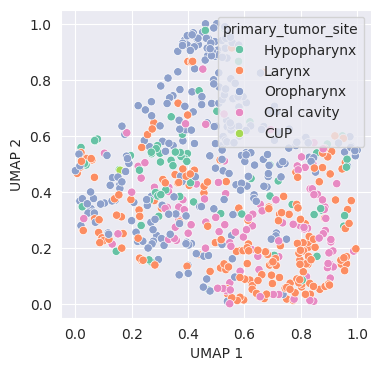

In [4]:
# Example
plt.figure(figsize=(4, 4))
sns.scatterplot(df, x="UMAP 1", y="UMAP 2", hue="primary_tumor_site", palette="Set2")
plt.show()

In [5]:
plt.style.use('default')
sns.set_style('ticks')
rcParams.update({"font.size": 6})
rcParams["svg.fonttype"] = "none"
plt.rcParams["legend.markerscale"] = 3

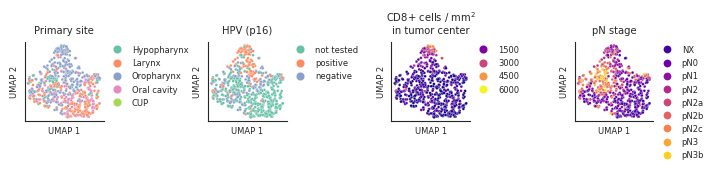

In [6]:
# Reproduce plots for Figure 2

titles = ["Primary site", "HPV (p16)", "CD8+ cells / mm$^2$\nin tumor center", "pN stage", "Grading"]
features = ["primary_tumor_site", "hpv_association_p16", "cd8_z", "pN_stage"]
fig, axes = plt.subplots(1, 4, figsize=(7, 2.5))

for i, feature in enumerate(features):
    
    if feature == "pN_stage":
        palette = sns.color_palette("plasma", n_colors=len(pn_stages))
        legend_handles = [
            plt.Line2D([0], [0], marker="o", color="w", label=label, markerfacecolor=color, markersize=2.2)
            for label, color in zip(pn_stages, palette)
        ]
        
    elif feature == "cd8_z":
        palette = "plasma"
        
    else:
        palette = sns.color_palette("Set2", n_colors=len(df[feature].unique()))
        legend_handles = None
        
    sns.scatterplot(df, x="UMAP 1", y="UMAP 2", hue=feature, palette=palette, s=4, ax=axes[i])
    sns.despine(ax=axes[i])

    # Axes
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_aspect("equal")

    # Title
    axes[i].set_title(titles[i])

    # Legend (outside plot at top right corner)
    axes[i].legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0,
                            frameon=False, handles=legend_handles, fontsize=6)
    
plt.tight_layout(pad=0.1)
plt.savefig("umap_plots.svg", bbox_inches="tight")
plt.show()

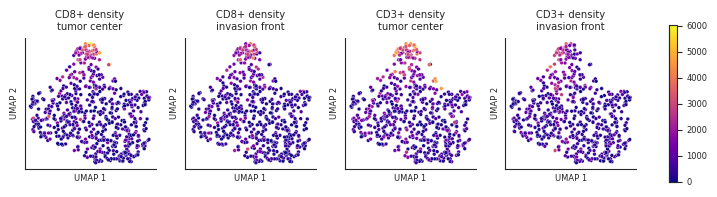

In [7]:
# Plot TMA cell densities with a common colorbar

titles = ["CD8+ density\ntumor center", "CD8+ density\ninvasion front", 
          "CD3+ density\ntumor center", "CD3+ density\ninvasion front"]
features = ["cd8_z", "cd8_inv", "cd3_z", "cd3_inv"]

fig, axes = plt.subplots(1, 4, figsize=(7, 2.5))

for i, feature in enumerate(features):
    palette = "plasma"
    
    # add a colorbar instead of the sampled legend
    cmap = sns.color_palette("plasma", as_cmap= True)
    sm = plt.cm.ScalarMappable(cmap= cmap, norm=plt.Normalize(df[features].min().min(), df[features].max().max()))
    scatter = sns.scatterplot(df, x="UMAP 1", y="UMAP 2", hue=feature, 
                              hue_norm=sm.norm, palette=cmap, legend= False, s=7, ax=axes[i]);
    
    # Axes
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_aspect("equal")

    # Title
    axes[i].set_title(titles[i])

        
plt.tight_layout(pad=2)
cbar = plt.colorbar(sm, ax=axes, fraction=0.012)
sns.despine()
plt.savefig("umap_celldensity.svg", bbox_inches="tight")
plt.show()

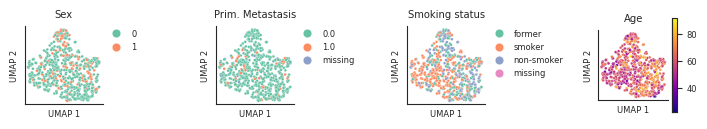

In [8]:
# Demographics
titles = ["Sex", "Prim. Metastasis", "Smoking status", "Age"]
features = ["sex", "primarily_metastasis", "smoking_status", "age_at_initial_diagnosis"]
numerical_features = ["age_at_initial_diagnosis"]
plot_umap(df, titles, features, numerical_features, filename="umap_demographics.svg")

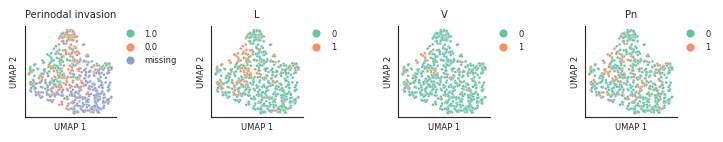

In [9]:
# Pathological features
titles = ["Perinodal invasion", "L", "V", "Pn"]
features = ["perinodal_invasion", "lymphovascular_invasion_L", "vascular_invasion_V", "perineural_invasion_Pn"]
numerical_features = []
plot_umap(df, titles, features, numerical_features, filename="umap_pathology.svg")

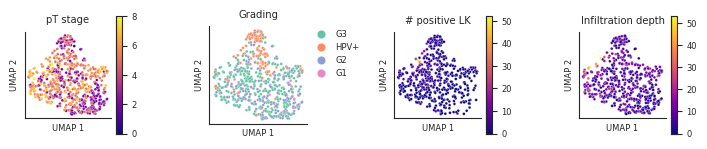

In [10]:
# Pathological features
titles = ["pT stage", "Grading", "# positive LK", "Infiltration depth"]
features = ["pT_stage", "grading", "number_of_positive_lymph_nodes", "infiltration_depth_in_mm"]
numerical_features = ["pT_stage", "number_of_positive_lymph_nodes", "infiltration_depth_in_mm"]
plot_umap(df, titles, features, numerical_features, filename="umap_pathology2.svg")

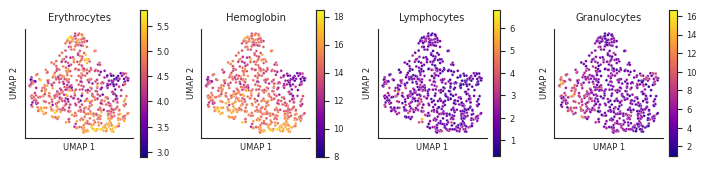

In [11]:
# Blood parameters
titles = ["Erythrocytes", "Hemoglobin", "Lymphocytes", "Granulocytes"]
features = [
    "Erythrocytes [#/volume] in Blood", 
    "Hemoglobin [Mass/volume] in Blood", 
    "Lymphocytes [#/volume] in Blood", 
    "Granulocytes [#/volume] in Blood"]
numerical_features = features
plot_umap(df, titles, features, numerical_features, filename="umap_blood.svg")

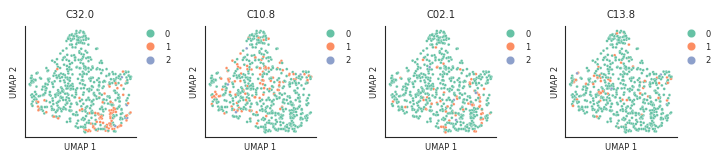

In [12]:
# ICD codes
titles = ["C32.0", "C10.8", "C02.1", "C13.8"]
features = ["c320", "c108", "c021", "c138"]
numerical_features = []
plot_umap(df, titles, features, numerical_features, filename="umap_icd.svg")